# 4.4 Evaluating models


In the last section we created a very simple model linking the binarised self reported health with the deprivation index controlled by age for the UK. We made emphasis on understanding the workings of the model and develop an intuition of what the model has learnt, but a modeling task is not complete without evaluation meaning examining how well the model has learned the data and is able generalise it in unseen data.

To evalulate how well the model can explain the data used for the fit there is a number of metrics that that describe the **goodness-of-fit** which summarises the discrepancy between observed values and the values expected under the model. These metrics depend of the kind of type you are fitting, e.g. in regression you tend to look at the *Mean Square Error*, *Root Mean Squared Error*, *Coefficient of Determination*, residual plots, etc. (although all these metrics have to be interpreted with the full knowdlege of the context of the data and model,  you can find more about these metrics in [here](https://medium.com/microsoftazure/how-to-better-evaluate-the-goodness-of-fit-of-regressions-990dbf1c0091)). 

The **goodness-of-fit** metrics alone are not enough for a full evaluation of the model. A fit can learn perfectly the data, but fail to make good predictions on future unseen samples. This is known as overfitting. Hence, part of model evaluation is to estimate the generalization accuracy of a model on unseen/out-of-sample data by using a **test set** (i.e data not seen by the model) to evaluate performance. 

In this section we will build on the modeling steps done in section 4.3 and perform model evaluation. In this example we are focusing on logistic regression, however we will try to make the concepts and ideas generasible to other models. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn import metrics
from matplotlib import pyplot

plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
sns.set_style("white")

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data processing

**Note**: *We aim that each section can function as a stand-alone material, therefore we repeate the data processing steps in Sections 3.5, 4.3 and now here. Feel free to skip to the next section.*

 We can access the data by downloading the csv option from here. Create a folder data in the same root as this notebook. Copy the folder UKDA-7724-csv and its contents there.

In [2]:
datafolder = 'data/UKDA-7724-csv/'
df11 = pd.read_csv(datafolder + 'csv/eqls_2011.csv')
df_map = pd.read_csv(datafolder + 'mrdoc/excel/eqls_api_map.csv', encoding='latin1')

In [3]:
# we are only interested in the UK for this example.
df11 = df11.query('Y11_Country == 27')

var_map = {"Y11_Q42": "SRH",
           'Y11_Deprindex': 'DeprIndex',
           "Y11_RuralUrban": "RuralUrban",
           "Y11_Accommproblems": 'AccomProblems',
           "Y11_HHsize": "HouseholdSize",
           "Y11_Q32": "Children",
           "Y11_ISCEDsimple":"ISCED",
           "Y11_Education": "Education",
           "Y11_SocExIndex":"SocialExclusionIndex",
           "Y11_MWIndex": "MentalWellbeingIndex",
           "Y11_Agecategory":"AgeCategory",
           "Y11_HH2a":"Gender",
           "Y11_Q31":"MaritalStatus",
           "Y11_Country":"Country"
}

df11.rename(columns=var_map, inplace=True)
df11_set = df11[var_map.values()]

We drop rows with missing data (**warning**: this shoudn't be done lightly without having explored the missigness of the data, here we are doing for simplicity and to focus on the modeling).

In [4]:
df11_model = df11_set.dropna() 

Finally, we dichotomise the `SRH` variable.

In [5]:
# dichotomoise SRH
df11_model['SRH_binary'] = df11_model.SRH.apply(lambda x: 1 if float(x) <= 3 else 0)

/anaconda3/envs/rds-course/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Model 1: Age and Deprivation index.

Let's start evaluating the performance of a simple model described in section 3.5 where we model `SRH` as a function of Age and Deprivation. In that section we use our complete UK dataset to fit the model as an ilustrative example, however this is not best practice at the time of building and evaluating models.  

It’s not recommended to use the data we used to build the model to evaluate it, the best approach is to partition your dataset into a **training** sample used to fit you model, and a **holdout** sample for evaluation. The purpose of this is to obtain an unbiased estimate of learning performance. 

Depending on your model you might need a **training**, **validation** and **testing** set (e.g a validation set can be useful when you have to tune model hyperparameters). However, for this example we will use a simple **train**/**test** split following a 70/30 rule (for more in depth discussion of what is a "good test size" check-out this [blog post](https://www.r-bloggers.com/2021/01/what-is-a-good-test-set-size-2/)).

In [6]:
# test train split using scikit learn, defining random state for reproducibility
trainX_model1, testX_model1, trainy_model1, testy_model1 = train_test_split(df11_model[['AgeCategory','DeprIndex']], df11_model.SRH_binary.values, test_size=0.3, random_state=2)

**Note**: In this example we will use a fixed train/test split, but this has its dangers — what if the split we make isn’t random? (e.g data could be ordered in a non random manner, or we could be unlucky in our split to have a non-representative sample). A solution for this is to use **cross-validation**. This method is very similar to train/test split, but it’s applied to more subsets. Meaning, the dataset is split into *k* subsets (or folds), and the model is trainned on k-1 one of those subsets. The remaining subset is used to test the model. This is done iteratively *k* times and then the score metrics obtained on each of the folds are averaged into a a summarized performance of the model. More information on **cross-validation** can be found [here](https://scikit-learn.org/stable/modules/cross_validation.html).


Now, let's fit our model on our training set.

In [7]:
trainX_const_model1 = sm.add_constant(trainX_model1) #add constant for intercept
logit_model_model1 = sm.Logit(trainy_model1, trainX_const_model1) #Create model instance
result_model1 = logit_model_model1.fit() #Fit model

Optimization terminated successfully.
         Current function value: 0.325243
         Iterations 7


/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In the output, ‘Iterations‘ refer to the number of times the model iterates over the data to optimize the model.

## Validating the fit
Let's explore the output of the fit. The summary table below gives us a descriptive summary about the results.  

In [8]:
print (result_model1.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1395
Model:                          Logit   Df Residuals:                     1392
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Oct 2021   Pseudo R-squ.:                 0.08318
Time:                        15:58:49   Log-Likelihood:                -453.71
converged:                       True   LL-Null:                       -494.88
Covariance Type:            nonrobust   LLR p-value:                 1.323e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.0847      0.349     11.692      0.000       3.400       4.769
AgeCategory    -0.4030      0.081     -4.950      0.000      -0.563      -0.243
DeprIndex      -0.3615      0.043     -8.317    

In section 4.3 we discussed the interpretation of the coefficitents, standard erros and significance parameters. In this section we'll explore the output related to the **goodness-of-fit**. 

- **Method**:  Maximum Likelihood Estimation (MLE) is a probabilistic framework for estimating the parameters of an assumed probability distribution, given some observed data. MLE involves maximizing a likelihood function in order to find the probability distribution and parameters that best explain the observed data.
- **No. Observations**: Number of observations on our training set.
- **Df. Residuals**:  This is the Degrees of Freedom in the model. This is calculated in the form of `number of observations` - `number of predictors` - 1.
- **Df. Model**: Degrees of Freedom of our model, which is basically the number of predictors used in the model (or number of coefficients to be fitted).
- **Log-Likelihood**: the natural logarithm of the Maximum Likelihood Estimation (MLE) function given the estimated parameters. The log likelihood function in maximum likelihood estimations is usually computationally simpler, and the log-likelihood maximum is the same as the likelihood maximum.
- **LL-Null**: the value of log-likelihood of the model when no independent variable is included (only an intercept is included).
- **Pseudo R-squ.**: It is the ratio of the log-likelihood of the null model to that of the full model (this can function as a substitute for the R-squared value in Least Squares linear regression).
- **LLR p-value**: A small p-value you can reject the null hypothesis that the model based on the intercept (all coefficients = 0) is better than the full model, again this uses the ratio of the log-likelihood of the null model to that of the full model.

For the remainder of this section we will be using the **Log-lilelihood** values as a way to compare how a model improves when adding a new predictor. 

## Evaluation thorugh prediction on new data

Now we test our model using our test dataset. 

First we obtain the prediction of the model as a a probability and  in order to use it as a classifier, we choose choose a threshold value. Where scores above this value will classified as positive, those below as negative. For now the threshold value of the probability is $prob(x)>0.5$.

In [9]:
# performing predictions on the test datdaset
yhat = result_model1.predict(sm.add_constant(testX_model1))
pred_y_model1 = list(map(round, yhat))
 
# comparing first 10 original and predicted values of y
print('Actual values', list(testy_model1)[:10])
print('Predictions :', pred_y_model1[:10])

Actual values [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predictions : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In the cell above we are just printing the first 10 observations of our dataset. In order to summarise the the accuracy of the predictions from our model we can use a confusion matrix. This maps the predicted and actual values into a matrix, can give us an idea of what the classification model is getting right and what types of errors it is making.

From a confusion matrix we can obtain the True Positives (TP), False Positives (FP), True Negatives (TN) and False Negatives (FN) and calculate the following metrics:


- $Accuracy = \frac{TP  + TN}{TP + FP + TN + FN}$


- $Precision = 
     \frac{TP}{TP + FP}$
     
     
- $Recall = 
      \frac{TP}{TP + FN}$
      
    

Accuracy: 0.8931552587646077
Precision: 0.8961474036850922
Recall: 0.9962756052141527


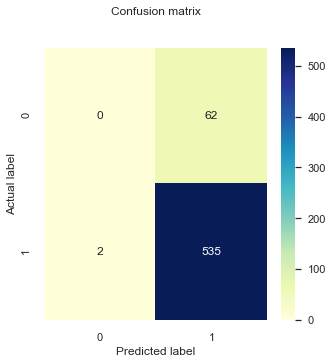

In [10]:
# confusion matrix using sklearn
cnf_matrix = metrics.confusion_matrix(testy_model1,pred_y_model1)

def plt_cnf_mat(cnf_matrix, ax, class_names=[0,1]):
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.set_title('Confusion matrix', y=1.1)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    
    
fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix, ax)


print("Accuracy:",metrics.accuracy_score(testy_model1, pred_y_model1))
print("Precision:",metrics.precision_score(testy_model1, pred_y_model1))
print("Recall:",metrics.recall_score(testy_model1, pred_y_model1)) # what is recall? 

You can see here the no negative values get predicted and the overwelming majority of responses are true positives. Furthermore, the accuracy, precision and recall score > 89%, this is happening due to our dataset being highly imbalanced and that the minority class are labeled as negative (0).

A better evaluation would be to estimate these metrics as a function of the minority class in the following way:



In [11]:
testy_model1_minority = abs(testy_model1 - 1)
pred_y_model1_minority = abs(np.array(pred_y_model1) -1)

print("Accuracy:",metrics.accuracy_score(testy_model1_minority, pred_y_model1_minority))
print("Precision:",metrics.precision_score(testy_model1_minority, pred_y_model1_minority))
print("Recall:",metrics.recall_score(testy_model1_minority, pred_y_model1_minority)) 

Accuracy: 0.8931552587646077
Precision: 0.0
Recall: 0.0


The results above are not a surprise. In 4.3 we saw that the model considers deprivation as a continous variable and observed that the cutoff point of the model (this is the value where the model starts predicive negative labels) for the deprivation predictor was around 7, which is larger than the existing range for this variable. Nonetheless, in our examination of the model in 4.3 we observed that the model was indeed learning from the data and reproducing it, and after examining the **log-likelihoods** of the fit summary above we can conclude that the model is indeed better than a null model where the predictors do not add any information.  

This means that the classification matrix, which show that our model is unable to ever predict the negative labels existing in the dataset might not be the best tool to evaluate the model in this scenario. Particularly because it shows a snapshot of the results being mapped from a predicted probability using a threshold of $p(x)> 0.5$.


### Investigating threshold values

Let's go back to our probability and investigate the predicted values given by the model for our two labels:

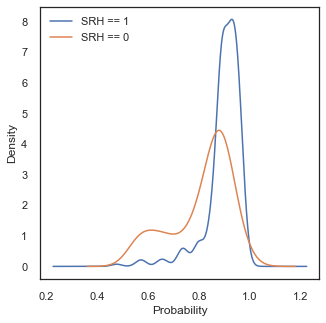

In [12]:
# link the prediction to the label values
df_labels = pd.DataFrame({'prediction': yhat,
     'label': testy_model1})

fig, ax = plt.subplots(1,1, figsize = (5,5))
df_labels[df_labels['label']==1]['prediction'].plot.kde(label='SRH == 1')
df_labels[df_labels['label']==0]['prediction'].plot.kde(label='SRH == 0')
pyplot.xlabel('Probability')
pyplot.legend()



Ideally, in this density plot we would observe the probability scores between two classes to be separated, with the score of the cases where `SRH==0` on the low probability values and the score of cases with `SRH==1` to be on the the high values. However, in the current case both distributions are slight skewed to the high probability values. The reason for this is because our dataset is highly imbalanced and only consists of 10 percent of cases where `SRH ==0`. Thus the predicted probabilities sort of gets pulled towards a higher values because of the majority of the data being positive cases.

In [13]:
print ('Mean value for SRH ==1,', round(df_labels[df_labels['label']==1]['prediction'].mean(),3))
print ('Mean value for SRH ==0,', round(df_labels[df_labels['label']==0]['prediction'].mean(),3))
print ('Percentage of cases with SRH ==0,', round(df_labels[df_labels['label']==0]['prediction'].count()/df_labels.shape[0],3))

Mean value for SRH ==1, 0.898
Mean value for SRH ==0, 0.812
Percentage of cases with SRH ==0, 0.104


Despite all this, in the density figures above we can observe a separation in the predicted scores, and the performance of the model could be improve dby selecting a better threshold value of the probability use to classify each case. This should be done by making a balance between the rate of False Positives and False Negatives. For this we can use other tools avalaible, such as **ROC curves**.

### What Are ROC Curves?

A receiver operating characteristic curve, or ROC curve, is a figure that illustrates the performance of a binary classifier as its discrimination threshold is varied.

Let's examine how the ROC courve looks for our model, and how it compares to a dummy classifier with no skill in classifying our data. 

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.766


/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


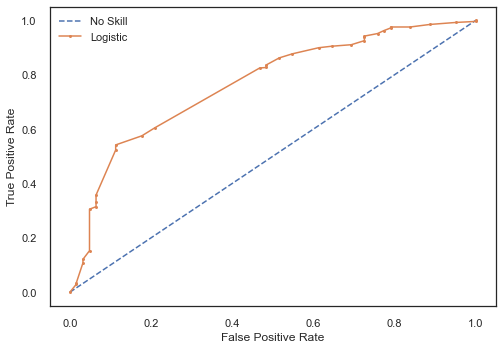

In [14]:
lr_probs_model1 = result_model1.predict(sm.add_constant(testX_model1))

ns_probs_model1 = [0 for _ in range(len(testy_model1))]
# keep probabilities for the positive outcome only
# calculate scores
ns_auc_model1 = roc_auc_score(testy_model1, ns_probs_model1)
lr_auc_model1 = roc_auc_score(testy_model1, lr_probs_model1)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc_model1))
print('Logistic: ROC AUC=%.3f' % (lr_auc_model1))
# calculate roc curves
ns_fpr_model1, ns_tpr_model1, _ = roc_curve(testy_model1, ns_probs_model1)
lr_fpr_model1, lr_tpr_model1, _ = roc_curve(testy_model1, lr_probs_model1)
# plot the roc curve for the model
pyplot.plot(ns_fpr_model1, ns_tpr_model1, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_model1, lr_tpr_model1, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

The AUC values printed above reflects the area under the ROC curve and provides a measure of how discriminant the model is between the two classes.  [In general, an AUC of 0.5 means no discrimination, 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding](https://www.sciencedirect.com/science/article/pii/S1556086415306043#:~:text=AREA%20UNDER%20THE%20ROC%20CURVE,-AUC%20is%20an&text=In%20general%2C%20an%20AUC%20of,than%200.9%20is%20considered%20outstanding.).

A value of 0.5 for AUC indicates that the ROC curve will fall on the diagonal (i.e., 45-degree line) and hence suggests that the diagnostic test has no discriminatory ability. 

Here we confirm again that we our model has learned something and performs better that a "unskilled" dummy classifier. Now, we can use the ROC values to obtain the optimal threshold value, which which maximises the True Positive rate and minimizes the False Positive rate.  

One of the commonly used method for this is the [Youden index method](https://en.wikipedia.org/wiki/Youden%27s_J_statistic). In this method the optimal threshold values is the one that maximises the Youden function which is the difference between true positive rate and false positive rate over all possible threshold values.

We wrote a small implementation of this method for this example:

In [15]:
# function inpired by https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def find_optimal_threshold(target, predicted):
    """ Find the optimal probability threshold for a classification model.
    Parameters
    ----------
    target : Matrix with label data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    a float, with optimal cutoff value
        
    """
    fpr, tpr, thresholds = roc_curve(target, predicted)
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

threshold = find_optimal_threshold(df_labels['label'], df_labels['prediction'])
print (round(threshold,4))

0.8997


This is quite far from the 0.5 value we orginially had! Let's see how our classification matrix does now using this new threshold.

Accuracy: 0.5692821368948247

Precision: 0.9761092150170648
Recall: 0.5325884543761639

Precision Minority Label: 0.17973856209150327
Recall Minority Label: 0.8870967741935484


/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


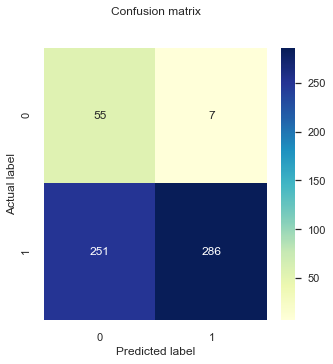

In [16]:


# performing predictions on the test datdaset
yhat = result_model1.predict(sm.add_constant(testX_model1))
pred_y_model1 =  [1 if x > threshold else 0 for x in yhat]


# confusion matrix using sklearn
cnf_matrix = metrics.confusion_matrix(testy_model1,pred_y_model1)
    
fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix, ax)


print("Accuracy:",metrics.accuracy_score(testy_model1, pred_y_model1))

print ()
print("Precision:",metrics.precision_score(testy_model1, pred_y_model1))
print("Recall:",metrics.recall_score(testy_model1, pred_y_model1)) # what is recall? 

print ()
testy_model1_minority = abs(testy_model1 - 1)
pred_y_model1_minority = abs(np.array(pred_y_model1) -1)

print("Precision Minority Label:",metrics.precision_score(testy_model1_minority, pred_y_model1_minority))
print("Recall Minority Label:",metrics.recall_score(testy_model1_minority, pred_y_model1_minority)) 

Using this new threshold values improves significantly the recall for our minority label (`SRH==0`), but a large expense of the classification performance of the mayority label (`SRH==1`). However, a model that puts all instances in one class is not of good use for us, so this is an improvement. Furthermore, depending of our research question and the ultimate goal of the model we might want to maximise the recall of the minority label, even if this means increasing the amount of false negatives we observe. For example, it might be more important to identify people that are likely to report poor health than the ones with good health.

In any case, we must remember that up to know we are using a very simple model, only using deprivation as a predictor and controling for age. Adding more predictors to the model can improve its performance. We'll explore that next.

## Model 2: Model 1 + Education, No. of Children and Accomodation Problems

In [17]:
trainX_model2, testX_model2, trainy_model2, testy_model2 = train_test_split(df11_model[['AgeCategory','DeprIndex','ISCED','Children',"AccomProblems"]], df11_model.SRH_binary.values, test_size=0.3, random_state=2)
trainX_const_model2 = sm.add_constant(trainX_model2) #add constant for intercept
logit_model2 = sm.Logit(trainy_model2, trainX_const_model2) #Create model instance
result_model2 = logit_model2.fit() #Fit model

Optimization terminated successfully.
         Current function value: 0.317076
         Iterations 7


/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.8662
Accuracy: 0.7646076794657763

Precision: 0.9541284403669725
Recall: 0.7746741154562383

Precision Minority Label: 0.25766871165644173
Recall Minority Label: 0.6774193548387096


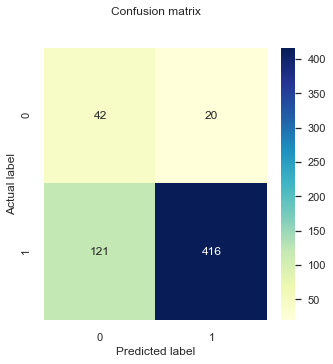

In [18]:
# performing predictions on the test datdaset
yhat_model2 = result_model2.predict(sm.add_constant(testX_model2))

threshold_model2 = find_optimal_threshold(testy_model2, yhat_model2)
print (round(threshold_model2,4))

pred_y_model2 =  [1 if x > threshold_model2 else 0 for x in yhat_model2]


cnf_matrix_model2  = metrics.confusion_matrix(testy_model2,pred_y_model2)

fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix_model2 , ax)


print("Accuracy:",metrics.accuracy_score(testy_model2 , pred_y_model2 ))

print()
print("Precision:",metrics.precision_score(testy_model2 , pred_y_model2 ))
print("Recall:",metrics.recall_score(testy_model2 , pred_y_model2 )) 


print ()
testy_model2_minority = abs(testy_model2 - 1)
pred_y_model2_minority = abs(np.array(pred_y_model2) -1)

print("Precision Minority Label:",metrics.precision_score(testy_model2_minority, pred_y_model2_minority))
print("Recall Minority Label:",metrics.recall_score(testy_model2_minority, pred_y_model2_minority)) 

In [19]:
print (result_model2.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1395
Model:                          Logit   Df Residuals:                     1389
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Oct 2021   Pseudo R-squ.:                  0.1062
Time:                        15:58:50   Log-Likelihood:                -442.32
converged:                       True   LL-Null:                       -494.88
Covariance Type:            nonrobust   LLR p-value:                 4.395e-21
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.2864      0.496      6.620      0.000       2.313       4.259
AgeCategory      -0.3592      0.088     -4.092      0.000      -0.531      -0.187
DeprIndex        -0.2929      0.046     

- Discuss Log-Likelihood as another way of measuring model performance (and comparing between models)

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


No Skill: ROC AUC=0.500
Logistic Simple Model: ROC AUC=0.766
Logistic: ROC AUC=0.757


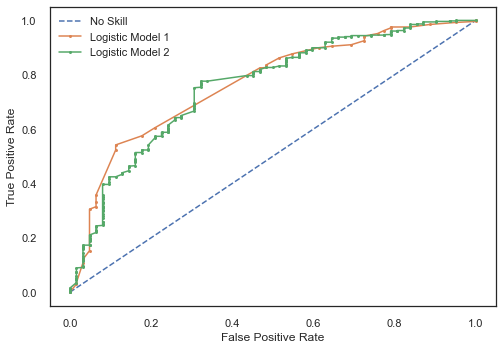

In [20]:
lr_probs_model2  = result_model2.predict(sm.add_constant(testX_model2 ))

ns_probs_model2 = [0 for _ in range(len(testy_model2))]
# keep probabilities for the positive outcome only
# calculate scores
ns_auc_model2  = roc_auc_score(testy_model2 , ns_probs_model2 )
lr_auc_model2  = roc_auc_score(testy_model2 , lr_probs_model2 )
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc_model2))
print('Logistic Simple Model: ROC AUC=%.3f' % (lr_auc_model1))
print('Logistic: ROC AUC=%.3f' % (lr_auc_model2))
# calculate roc curves
ns_fpr_model2 , ns_tpr_model2 , _ = roc_curve(testy_model2, ns_probs_model2)
lr_fpr_model2 , lr_tpr_model2 , _ = roc_curve(testy_model2, lr_probs_model2)
# plot the roc curve for the model
pyplot.plot(ns_fpr_model2, ns_tpr_model2, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_model1, lr_tpr_model1, marker='.', label='Logistic Model 1 ')
pyplot.plot(lr_fpr_model2, lr_tpr_model2, marker='.', label='Logistic Model 2')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- Talk about information gained from more complicated model. 

- Go back to our research question: talk about how to know that a variable has importance in the model.

## Model 3

- Add a couple more variables:
    - Mental health
    - Social exclusion
    - Disucus how these variables were taken.

In [21]:
X = df11_model[['AgeCategory','DeprIndex','ISCED','MentalWellbeingIndex','Children',"SocialExclusionIndex","AccomProblems"]]
y = df11_model.SRH_binary.values

trainX_model3, testX_model3, trainy_model3, testy_model3 = train_test_split(X, y, test_size=0.3, random_state=2)
trainX_const_model3 = sm.add_constant(trainX_model3) #add constant for intercept
logit_model3 = sm.Logit(trainy_model3, trainX_const_model3) #Create model instance
result_model3 = logit_model3.fit() #Fit model


print (result_model3.summary())

Optimization terminated successfully.
         Current function value: 0.273033
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1395
Model:                          Logit   Df Residuals:                     1387
Method:                           MLE   Df Model:                            7
Date:                Thu, 07 Oct 2021   Pseudo R-squ.:                  0.2304
Time:                        15:58:51   Log-Likelihood:                -380.88
converged:                       True   LL-Null:                       -494.88
Covariance Type:            nonrobust   LLR p-value:                 1.320e-45
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.3604      0.744      3.174      0.002       0.903       3.818

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.8884
Accuracy: 0.7746243739565943

Precision: 0.9631336405529954
Recall: 0.7783985102420856

Precision Minority Label: 0.2787878787878788
Recall Minority Label: 0.7419354838709677


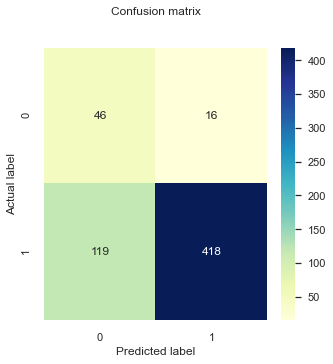

In [22]:
# performing predictions on the test datdaset
yhat_model3 = result_model3.predict(sm.add_constant(testX_model3))

threshold_model3 = find_optimal_threshold(testy_model3, yhat_model3)
print (round(threshold_model3,4))

pred_y_model3 =  [1 if x > threshold_model3 else 0 for x in yhat_model3]


cnf_matrix_model3  = metrics.confusion_matrix(testy_model2,pred_y_model3)

fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix_model3 , ax)


print("Accuracy:",metrics.accuracy_score(testy_model3 , pred_y_model3 ))

print()
print("Precision:",metrics.precision_score(testy_model3 , pred_y_model3 ))
print("Recall:",metrics.recall_score(testy_model3 , pred_y_model3 )) 


print ()
testy_model3_minority = abs(testy_model3 - 1)
pred_y_model3_minority = abs(np.array(pred_y_model3) -1)

print("Precision Minority Label:",metrics.precision_score(testy_model3_minority, pred_y_model3_minority))
print("Recall Minority Label:",metrics.recall_score(testy_model3_minority, pred_y_model3_minority)) 

- Discuss improvement in classification, and log likelihood.

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


No Skill: ROC AUC=0.500
Logistic Simple Model: ROC AUC=0.766
Logistic: ROC AUC=0.805


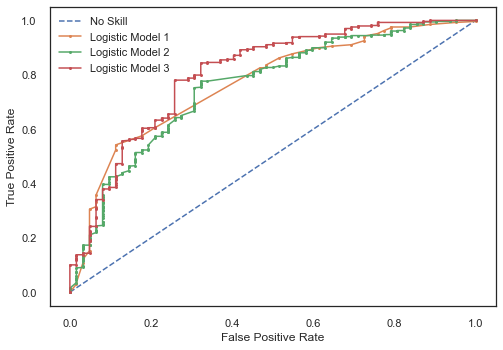

In [23]:
lr_probs_model3 = result_model3.predict(sm.add_constant(testX_model3))

ns_probs_model3 = [0 for _ in range(len(testy_model3))]
# keep probabilities for the positive outcome only
# calculate scores
lr_auc_model3 = roc_auc_score(testy_model3, lr_probs_model3)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc_model2))
print('Logistic Simple Model: ROC AUC=%.3f' % (lr_auc_model1))
print('Logistic: ROC AUC=%.3f' % (lr_auc_model3))
# calculate roc curves
ns_fpr_model3, ns_tpr_model3, _ = roc_curve(testy_model3, ns_probs_model3)
lr_fpr_model3, lr_tpr_model3, _ = roc_curve(testy_model3, lr_probs_model3)
# plot the roc curve for the model
pyplot.plot(ns_fpr_model3, ns_tpr_model3, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_model1, lr_tpr_model1, marker='.', label='Logistic Model 1')
pyplot.plot(lr_fpr_model2, lr_tpr_model2, marker='.', label='Logistic Model 2')
pyplot.plot(lr_fpr_model3, lr_tpr_model3, marker='.', label='Logistic Model 3')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- Discuss what the Aldabe paper does.